In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

image_paths = []
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        image_paths.append(os.path.join(dirname, filename))


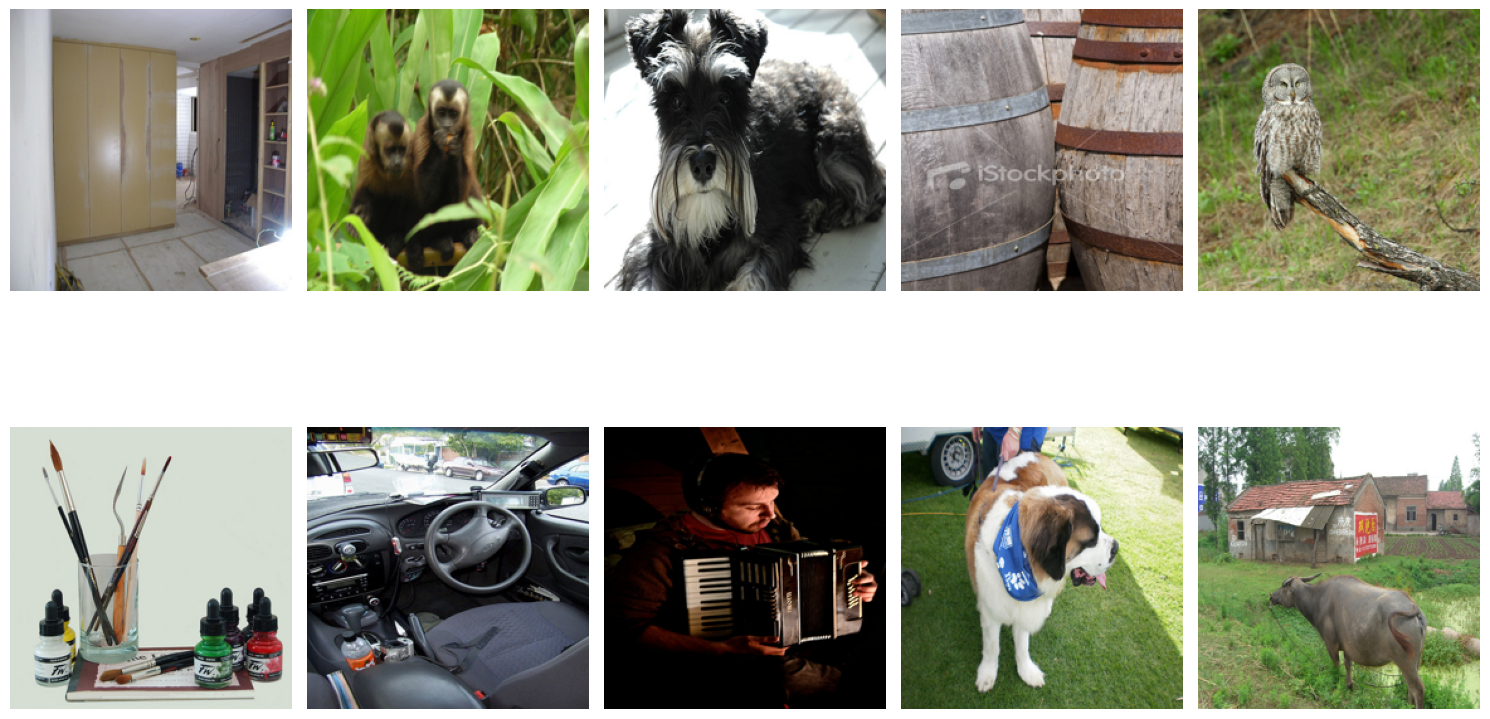

In [ ]:
import random
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
random_images = random.sample(image_paths, 10)

for i, image_file in enumerate(random_images):
    ax = axes[i // 5, i % 5]
    image = Image.open(image_file)
    resized_image = np.array(image.resize((224, 224))) / 255
    ax.imshow(resized_image)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SubsetImageNetDataset(Dataset):
    def __init__(self, root, transform_x=None, transform_y=None, num_samples=2000, random_seed=42,  meu=0, sigma=15,case1 = True):

        random.seed(random_seed)
        np.random.seed(random_seed)

        self.transform_x = transform_x
        self.transform_y = transform_y
        self.num_samples = num_samples

        full_dataset_paths = [os.path.join(root, filename) for filename in os.listdir(root)]
        self.samples = random.choices(full_dataset_paths, k=num_samples)

        self.meu = meu
        self.sigma = sigma
        self.case1 = case1

    def __len__(self):
        return len(self.samples)

    def add_gaussian_noise(self, image):

        noise = np.random.normal(self.meu, self.sigma, image.shape).astype(np.uint8)

        # Add noise to the image
        noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

        return noisy_image



    def __getitem__(self, idx):
        img_path = self.samples[idx]

        img = np.array(Image.open(img_path).convert('RGB'))

        img = Image.fromarray(img).resize((224, 224))

        img = np.array(img)
#         plt.imshow(img)
#         plt.show()
        if self.case1:
            noisy_image = self.add_gaussian_noise(img)
#         plt.imshow(noisy_image)
#         plt.show()
        if self.transform_x:
            img = self.transform_x(image = img)['image']

        if self.case1:
            if self.transform_y:
                noisy_image = self.transform_y(image = noisy_image)['image']
        if self.case1:
            return noisy_image, img
        else:
            return img

temp_transform = A.Compose([
    ToTensorV2(),
])
train_transform_x = A.Compose([
    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=[0.4788, 0.4594, 0.4226], std=[0.2747, 0.2694, 0.2857]),
    ToTensorV2(),
])

train_transform_y = A.Compose([

    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=[0.4735, 0.4498, 0.4017], std=[0.2748, 0.2680, 0.2814]),
    ToTensorV2(),
])

val_transform_x = A.Compose([

    A.Normalize(mean=[0.4833, 0.4661, 0.4249], std=[0.2629, 0.2551, 0.2725]),
    ToTensorV2(),
])

val_transform_y = A.Compose([
    A.Normalize(mean=[0.4836, 0.4595, 0.4096], std=[0.2616, 0.2521, 0.2676]),
    ToTensorV2(),
])
# train input mean : tensor([0.4788, 0.4594, 0.4226])
# train input std : tensor([0.2747, 0.2694, 0.2857])
# train target mean : tensor([0.4735, 0.4498, 0.4017])
# train target std : tensor([0.2748, 0.2680, 0.2814])

# validation input mean : tensor([0.4833, 0.4661, 0.4249])
# validation input std : tensor([0.2629, 0.2551, 0.2725])
# validation target mean : tensor([0.4836, 0.4595, 0.4096])
# validation target std : tensor([0.2616, 0.2521, 0.2676])

train_dataset_path = '/kaggle/input/imagenet/imagenet/train'
val_dataset_path = '/kaggle/input/imagenet/imagenet/val'

# Create datasets and data loaders
train_dataset = SubsetImageNetDataset(root=train_dataset_path, transform_x=train_transform_x,transform_y=train_transform_y, num_samples=4000)
val_dataset = SubsetImageNetDataset(root=val_dataset_path, transform_x=val_transform_x , transform_y=val_transform_y , num_samples=100)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(train_loader))
print(len(val_loader))

125
4


In [ ]:
input_, target_ = next(iter(train_loader))

In [ ]:
torch.min(input_) , torch.max( target_)

(tensor(-1.7231), tensor(2.0210))

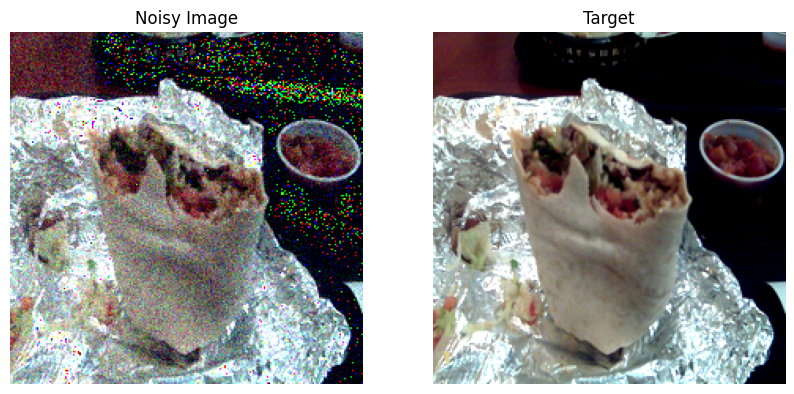

In [ ]:
fig, axs = plt.subplots(1,acos 2, figsize=(10, 5))

axs[0].imshow(np.transpose((input_[0] + 1) / 2, (1, 2, 0)))
axs[0].set_title('Noisy Image')

axs[1].imshow(np.transpose((target_[0] +1 ) / 2, (1, 2, 0)))
axs[1].set_title('Target')

for ax in axs:
    ax.axis('off')

plt.show()

In [ ]:
from tqdm import tqdm

def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum_data,channels_sum_target, channels_sqrd_sum_data,channels_sqrd_sum_target, num_batches = 0, 0, 0,0,0

    for data,target in tqdm(loader):
        #data, target = data.to(device), target.to(device)
        data = data / 255.0
        target = target / 255.0

        channels_sum_data += torch.mean(data, dim=[0, 2, 3])
        channels_sum_target += torch.mean(target, dim=[0, 2, 3])

        channels_sqrd_sum_data += torch.mean(data**2, dim=[0, 2, 3])
        channels_sqrd_sum_target += torch.mean(target**2, dim=[0, 2, 3])

        num_batches += 1

    mean_data  = channels_sum_data / num_batches
    mean_target = channels_sum_target / num_batches

    std_data   = (channels_sqrd_sum_data / num_batches - mean_data**2) ** 0.5
    std_target = (channels_sqrd_sum_target / num_batches - mean_target**2) ** 0.5


    return (mean_data,
            std_data,
            mean_target,
            std_target, )

In [ ]:
res = get_mean_std(train_loader)
print(f'train input mean : {res[0]}')
print(f'train input std : {res[1]}')

print(f'train target mean : {res[2]}')
print(f'train target std : {res[3]}')

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]

train input mean : tensor([0.4788, 0.4594, 0.4226])
train input std : tensor([0.2747, 0.2694, 0.2857])
train target mean : tensor([0.4735, 0.4498, 0.4017])
train target std : tensor([0.2748, 0.2680, 0.2814])


In [ ]:
res_val = get_mean_std(val_loader)
print(f'validation input mean : {res_val[0]}')
print(f'validation input std : {res_val[1]}')

print(f'validation target mean : {res_val[2]}')
print(f'validation target std : {res_val[3]}')

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

validation input mean : tensor([0.4833, 0.4661, 0.4249])
validation input std : tensor([0.2629, 0.2551, 0.2725])
validation target mean : tensor([0.4836, 0.4595, 0.4096])
validation target std : tensor([0.2616, 0.2521, 0.2676])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

encoder = Encoder()
decoder = Decoder()

dummy_input = torch.randn(1, 3, 224, 224)
encoded_output = encoder(dummy_input)
decoded_output = decoder(encoded_output)

print("Input shape:", dummy_input.shape)
print("Encoded output shape:", encoded_output.shape)
print("Decoded output shape:", decoded_output.shape)


Input shape: torch.Size([1, 3, 224, 224])
Encoded output shape: torch.Size([1, 256, 14, 14])
Decoded output shape: torch.Size([1, 3, 224, 224])


In [ ]:
256*14*14 , 3*224*224

(50176, 150528)

In [ ]:
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval()
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [ ]:
class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        loss = torch.mean(torch.sqrt(diff * diff + self.eps ** 2))
        return loss

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10
alpha = 1
beta = 5e-2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
autoencoder = Autoencoder().to(device)
vgg_loss = VGGLoss().to(device)
criterion = CharbonnierLoss()

optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
def test_vggloss():
    input_1 = torch.randn(1,3,224,224).to(device)
    input_2 = torch.randn(1,3,224,224).to(device)
    loss = vgg_loss(input_1, input_2)
    print(loss)
test_vggloss()

tensor(0.0178, device='cuda:0')


In [ ]:
from tqdm import tqdm

def evaluate_autoencoder(autoencoder, dataloader, cri, vgg, device):
    autoencoder.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    tqdm_loader = tqdm(dataloader, desc='Evaluation', dynamic_ncols=True)

    with torch.no_grad():
        for data in tqdm_loader:
            inputs, targets = data

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = autoencoder(inputs)
            mse = criterion(outputs, targets)
#             loss_vgg = vgg(outputs,targets)
#             total_loss = (mse * alpha) + (loss_vgg * beta)
            running_loss += mse.item()

            tqdm_loader.set_postfix(loss=running_loss / len(tqdm_loader))

    average_loss = running_loss / len(dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}')

evaluate_autoencoder(autoencoder, val_loader, criterion, vgg_loss, device)

Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s, loss=0.832]

Evaluation Loss: 0.8325


In [ ]:
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)
    counter = 0
    for data in tqdm_loader:
        inputs, targets = data

        inputs, targets = inputs.to(device), targets.to(device)

        outputs = autoencoder(inputs)

        L1_loss = criterion(outputs, targets)
        loss_vgg = vgg_loss(outputs, targets)
        totall_loss = alpha * L1_loss + beta * loss_vgg

        optimizer.zero_grad()
        totall_loss.backward()
        optimizer.step()

        running_loss += L1_loss.item()
        counter += 1
        tqdm_loader.set_postfix(loss=running_loss / counter)

    average_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}')

    if (epoch + 1) % 2 == 0:
        eval_loss = evaluate_autoencoder(autoencoder, val_loader, criterion, vgg_loss, device)


Epoch 1/10: 100%|██████████| 125/125 [04:04<00:00,  1.95s/it, loss=0.367]


Epoch [1/10], Training Loss: 0.3667


Epoch 2/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.335]


Epoch [2/10], Training Loss: 0.3352


Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, loss=0.312] 


Evaluation Loss: 0.3119


Epoch 3/10: 100%|██████████| 125/125 [04:02<00:00,  1.94s/it, loss=0.311]


Epoch [3/10], Training Loss: 0.3106


Epoch 4/10: 100%|██████████| 125/125 [04:03<00:00,  1.94s/it, loss=0.308]


Epoch [4/10], Training Loss: 0.3076


Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, loss=0.301] 


Evaluation Loss: 0.3006


Epoch 5/10: 100%|██████████| 125/125 [04:02<00:00,  1.94s/it, loss=0.299]


Epoch [5/10], Training Loss: 0.2992


Epoch 6/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.293]


Epoch [6/10], Training Loss: 0.2932


Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, loss=0.291] 


Evaluation Loss: 0.2915


Epoch 7/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.294]


Epoch [7/10], Training Loss: 0.2937


Epoch 8/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.289]


Epoch [8/10], Training Loss: 0.2887


Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s, loss=0.288] 


Evaluation Loss: 0.2879


Epoch 9/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.285]


Epoch [9/10], Training Loss: 0.2853


Epoch 10/10: 100%|██████████| 125/125 [04:03<00:00,  1.95s/it, loss=0.287]


Epoch [10/10], Training Loss: 0.2872


Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s, loss=0.288]

Evaluation Loss: 0.2883


there was a prior 5 epochs training before this that made the loss descent from 1.7 to 0.38 then i lowered the learning rate and continoued the training

In [ ]:
tensor = torch.randn(2,3,224,224)
print(tensor[0].shape)

torch.Size([3, 224, 224])


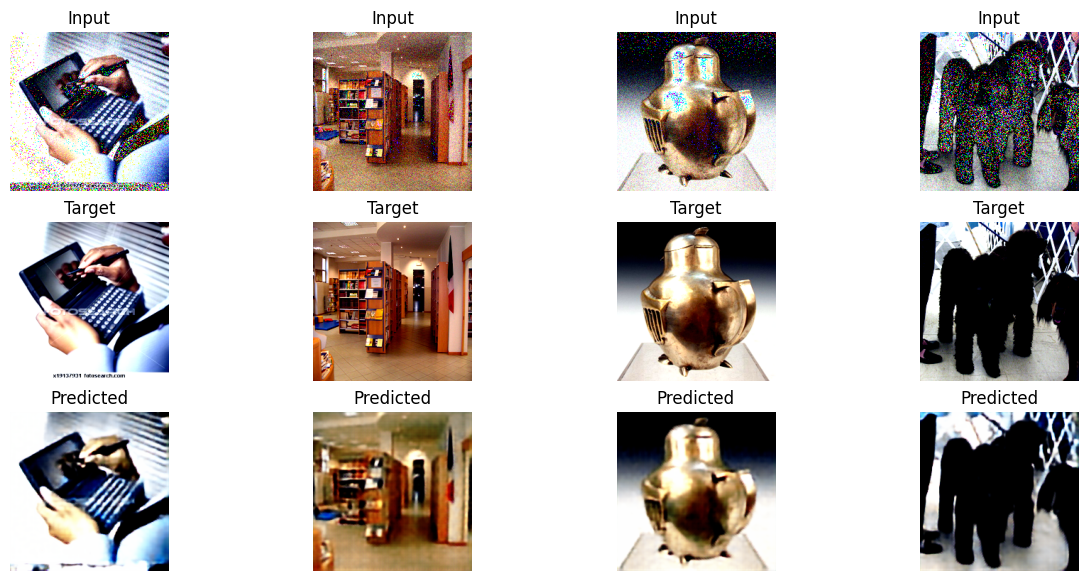

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def visualize_samples_noise_before_propagating(model, dataloader, num_samples=5, device='cuda'):
    model.eval()

    with torch.no_grad():
        input_images, target_images = next(iter(dataloader))
        input_images, target_images = input_images.to(device), target_images.to(device)

        predicted_images = model(input_images)

    input_images = input_images.detach().to('cpu').permute(0,2,3,1)
    target_images = target_images.detach().to('cpu').permute(0,2,3,1)
    predicted_images = predicted_images.detach().to('cpu').permute(0,2,3,1)

    plt.figure(figsize=(15, 7))

    for i in range(num_samples):
        ran = random.randint(0, 31)
        plt.subplot(3, num_samples, i + 1)
        plt.imshow((input_images[ran]+1)/2)
        plt.title('Input')
        plt.axis('off')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow((target_images[ran]+1)/2)
        plt.title('Target')
        plt.axis('off')

        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(((predicted_images[ran]+1)/2))
        plt.title('Predicted')
        plt.axis('off')

    plt.show()

visualize_samples(autoencoder, val_loader, num_samples=4, device=device)

In [ ]:
def add_gaussian_noise(code):

    noise = np.random.normal(0, 0.1, code.shape)

    # Add noise to the image
    noisy_image = code + noise

    return noisy_image

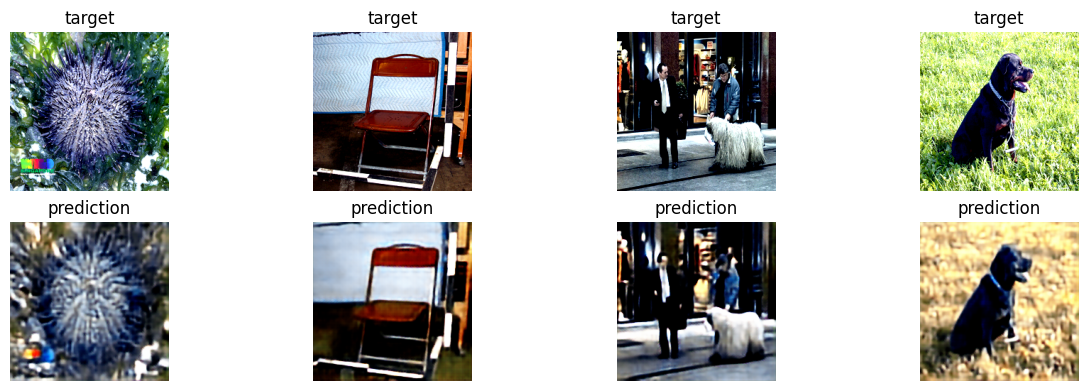

In [ ]:
def visualize_samples_noise_after_encoder(model, dataloader, num_samples=5, device='cuda'):
    model.eval()

    with torch.no_grad():
        _, target_images = next(iter(dataloader))
        target_images = target_images.to(device)

        code = model.encoder(target_images)
        noise = torch.empty(code.shape).normal_(mean=0, std=0.1).to(device)
        noisy_code = code + noise
        prediction = model.decoder(noisy_code)


    target_images = target_images.detach().to('cpu').permute(0,2,3,1)
    predicted_images = prediction.detach().to('cpu').permute(0,2,3,1)

    plt.figure(figsize=(15, 7))

    for i in range(num_samples):
        ran = random.randint(0, 31)
        plt.subplot(3, num_samples, i + 1)
        plt.imshow((target_images[ran]+1)/2)
        plt.title('target')
        plt.axis('off')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow((predicted_images[ran]+1)/2)
        plt.title('prediction')
        plt.axis('off')

    plt.show()

visualize_samples_noise_after_encoder(autoencoder, val_loader, num_samples=4, device=device)

# the noise is added directly to the code and it seems like it's changing some of the general featrures of the image like the color of the gras in the image on the right, so adding the noise to the image first seems a better approch

In [ ]:
input__, target__ = next(iter(train_loader))

In [ ]:
input_image, target_image = input__[0].permute(1,2,0), target__[0].permute(1,2,0)

In [ ]:
input_image.shape

torch.Size([224, 224, 3])

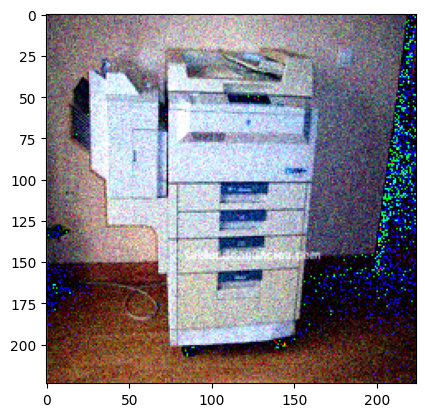

In [ ]:
plt.imshow((input_image+1) / 2)
plt.show()

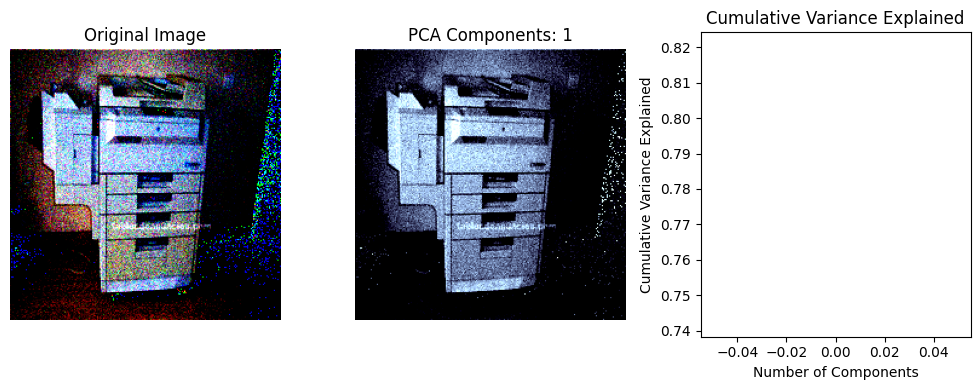

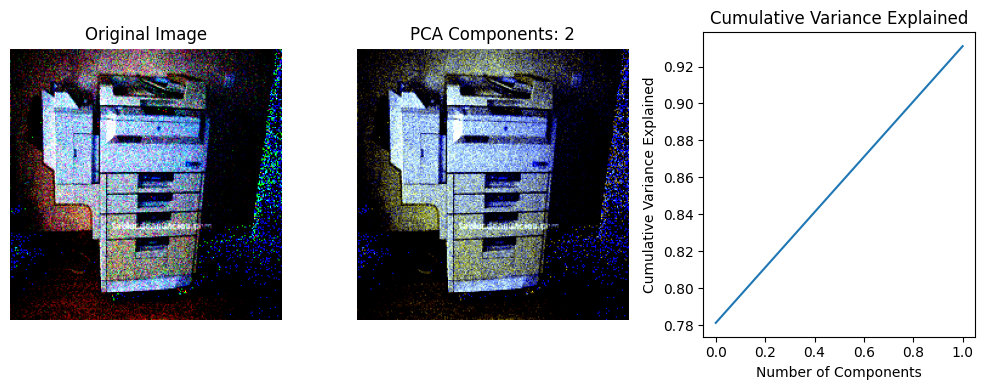

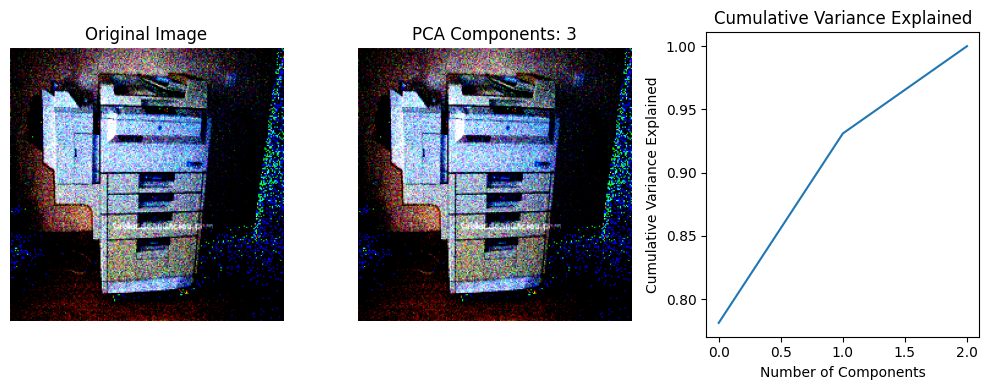

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

flat_image = input_image.view(-1, 3).numpy()

num_components_list = [1, 2, 3]

for num_components in num_components_list:
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(flat_image)

    reconstructed_image = pca.inverse_transform(pca_result)

    reconstructed_image = torch.from_numpy(reconstructed_image).view(224, 224, 3)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image.numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_image.numpy())
    plt.title(f"PCA Components: {num_components}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title("Cumulative Variance Explained")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")

    plt.tight_layout()
    plt.show()


# The PCA with small number of principle components filters the noise but losses s much important information, and as the number of principle components increases it caputures more noise as well as more information, so PCA is not a good choice for denoising.